_Ce notebook propose une application en NLP (analyse de sentiment binaire) avec deux modèles relevant respectivement du machine learning et du deep learning: le boosting de gradient et une variante de réseau de neurones récurrent. L'intérêt de cet exercice est entre autres d'illustrer sommairement deux aproches du prétraitement des données textuelles._

# Analyse de sentiments

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

On utilise le dataset __IMDb__ qui recense 50000 critiques de films et de séries (variable _review_), chacune associée à un label indiquant le sentiment général exprimé, positif ou négatif (variable _sentiment_).

In [138]:
imdb = pd.read_csv('Machine_Learning/imdb.csv')
print(imdb.shape)
imdb.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [139]:
# Séparation des features et de la cible
X, y = imdb.iloc[:,0].to_numpy(), imdb.iloc[:,1].to_numpy()

# Recodage de la cible qualitative binaire
y[y=='positive'] = 1
y[y=='negative'] = 0
y = y.astype('int')

# Dissociation de l'ensemble d'apprentissage (80%) et de l'ensemble de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=10)

## Modèle 1 : Gradient Boosting

Pour recourir au _gradient boosting_, il faut d'abord transformer nos données de manière à les rendre utilisables par l'algorithme.

On utilise ici la fonction `CountVectorizer()` afin d'opérer les transformations suivantes :
* chaque document (chaque critique) est _tokenisé_, c'est-à-dire découpé en sous-chaînes de caractères qui peuvent être des mots entiers comme ici, des fractions ou des groupes de mots de longueur définie ;
* les _tokens_ obtenus à partir des documents de l'ensemble d'apprentissage sont ensuite référencés dans un dictionnaire et identifiés par un entier unique ;
* chaque document est alors transformé en vecteur de même longueur que le dictionnaire : la valeur d'indice $i$ du vecteur correspond au nombre d'occurrences du mot identifié par la valeur $i$ dans le dictionnaire.

La longueur du dictionnaire peut être contrôlée pour améliorer les résultats et réduire la taille des documents vectorisés : en plus de la liste par défaut de ___stop words___ qui en sont exclus (les mots les plus fréquents de la langue choisie : les articles par exemple), on peut limiter le dictionnaire aux $n$ mots les plus fréquents parmi les documents et/ou supprimer les mots présents dans plus de 50% d'entre eux.

Cette suite d'opérations revient à appliquer l'algorithme dit du __sac de mots (_bag of words_)__ : la représentation obtenue est relativement pauvre en signification puisqu'on perd le contexte d'utilisation des _tokens_ mais elle est facile à implémenter et donne des résultats satisfaisants pour des tâches simples de classification textuelle.

In [140]:
# On initialise un objet CountVectorizer qui ignore les mots présents dans plus de 50% des documents
# et qui sélectionne les 5000 mots les plus fréquents parmi ceux qui restent
vectorizer = CountVectorizer(max_features=5000, max_df=.5)

# Ajustement sur les données d'apprentissage (création du dictionnaire) et transformation
X_trainV = vectorizer.fit_transform(X_train)
X_testV = vectorizer.transform(X_test)

# L'ensemble d'apprentissage devient une matrice contenant 40000 lignes (observations)
# et 5000 colonnes (une par mot du dictionnaire)
X_train.shape

(40000,)

In [141]:
# Exemple de document
X_train[0]

"What a terrible film.<br /><br />It starts well, with the title sequence, but that's about as good as it gets.<br /><br />The movie is something about rats turning into monsters and going on a killing spree. The acting isn't so much poor, but the script is pointless and the film isn't even scary despite the atmospheric music.<br /><br />It really is amazing that some group cobbled together this bag of rubbish and thought it would make a good film.<br /><br />It isn't a good film. It's trash, and I urge you not to waste a minute of your life on it! One out of ten."

In [142]:
# Représentation "sac de mots"
X_trainV.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [143]:
# Illustration des tokens obtenus pour le document en exemple
vectorizer.get_feature_names_out()[X_trainV.toarray()[0]>0]

array(['about', 'acting', 'amazing', 'atmospheric', 'bag', 'despite',
       'even', 'gets', 'going', 'good', 'group', 'into', 'isn', 'killing',
       'life', 'make', 'minute', 'monsters', 'much', 'music', 'out',
       'pointless', 'poor', 'really', 'rubbish', 'scary', 'script',
       'sequence', 'so', 'some', 'something', 'starts', 'ten', 'terrible',
       'thought', 'title', 'together', 'trash', 'turning', 'urge',
       'waste', 'well', 'what', 'would', 'your'], dtype=object)

In [144]:
# Fréquence de chaque token identifié
X_trainV[0].toarray()[X_trainV[0].toarray()>0]

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int64)

Avec cette nouvelle représentation des données, on peut ajuster un modèle de _gradient boosting_. 

Pour rappel, son algorithme se résume à :
* partir d'une prédiction aléatoire pour la variable cible ;
* ajuster un arbre de décision pour retrouver l'erreur obtenue à partir des variables explicatives ;
* ajouter au modèle de base la prédiction de l'arbre de décision réduite d'un facteur appelé taux d'apprentissage ;
* mettre à jour l'erreur ;
* ajuster un nouvel arbre sur l'erreur mise à jour et ainsi de suite jusqu'à atteindre un critère d'arrêt (avoir créé $x$ arbres par exemple).

Le modèle présente donc 3 hyperparamètres : le nombre d'estimateurs à créer, le taux d'apprentissage et la profondeur maximale de chaque arbre. On les optimise par __cross-validation__ ; les résultats sont présentés ci-dessous.

In [145]:
# Le code est neutralisé pour ne pas ralentir les exécutions ultérieures du notebook

# grid = {'n_estimators': [100, 200],
#        'learning_rate' : [0.5, 1],
#        'max_depth' : [1, 3, 5]}

# rfCross = GridSearchCV(estimator=GradientBoostingClassifier(),
#                          param_grid=grid,
#                          scoring='accuracy',
#                          cv=10
#                         )

# rfCross.fit(X_trainV, y_train)

# print(f"\nAccuracy moyenne maximale : {rfCross.best_score_} \nAtteinte pour n_estimators = {rfCross.best_params_['n_estimators']}, learning_rate = {rfCross.best_params_['learning_rate']} et max_depth = {rfCross.best_params_['max_depth']}")


Accuracy moyenne maximale : 0.8704000000000001 
Atteinte pour n_estimators = 200, learning_rate = 0.5 et max_depth = 3


In [146]:
clf = GradientBoostingClassifier(n_estimators=200,
                                learning_rate=0.5,
                                max_depth=3,
                                random_state=42)
clf.fit(X_trainV, y_train)
y_pred = clf.predict(X_testV)

In [147]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      5108
           1       0.85      0.89      0.87      4892

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Avec les meilleurs paramètres obtenus, on atteint un score d'exactitude de 87 % sur l'ensemble de test, c'est à dire qu'on prédit correctement le sentiment positif ou négatif des critiques dans 87 % des cas.

## Modèle 2 : réseau de neurones récurrent (RNN)

In [21]:
from tensorflow import keras
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras import Sequential
import matplotlib.pyplot as plt

Les données IMDb déjà tokenisées peuvent être importées directement via _keras_. On limite le dictionnaire aux 5000 mots les plus fréquents.

In [22]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

A la différence du modèle précédent, la structure de réseau de neurones récurrent permet de traiter les données de manière séquentielle : les mots sont ainsi traités par ordre d'apparition dans le document concerné. Il devient ainsi possible de tenir compte du contexte dans lequel ils sont employés.

Il faut cependant que les données fournies en entrée du réseau soient de même format : après avoir remarqué que la grande majorité des commentaires contiennent moins de 500 mots, on entreprend de raccourcir ou prolonger les séquences (quitte à les combler par des valeurs neutres) afin qu'elles contiennent exactement 500 valeurs.

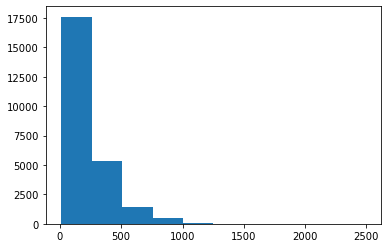

In [23]:
plt.hist([len(x) for x in X_train])
plt.show()

In [24]:
X_train = pad_sequences(X_train, maxlen=500)
X_test = pad_sequences(X_test, maxlen=500)

In [25]:
X_train.shape

(25000, 500)

En termes de représentation des données, on incorpore cette fois à notre réseau une couche dite d'_embedding_. L'___embedding___ ou "plongement lexical" consiste à décrire chaque mot de la séquence par un vecteur de réels plutôt qu'un vecteur _one-hot_ de la taille du dictionnaire. L'intérêt de cette technique est double puisqu'en plus de réduire la taille des données, elle permet d'identifier par des vecteurs proches des mots employés dans des contextes similaires. Les vecteurs associés à chaque mot sont déterminés par rétro-propagation de l'erreur au cours de l'ajustement du réseau.

On utilise de surcroît une forme particulière de réseau récurrent, qualifiée de ___long-short term memory___ : en plus d'inclure l'output $n-1$ au calcul de l'output $n$ à partir de l'input $n$ (mémoire de court terme), un réseau LSTM intègre un reliquat des outputs plus lointains (mémoire de long terme). Là encore, cette architecture aide à tenir compte de la séquence dans son ensemble et du sens porté par la phrase ou le document entier, au-delà du simple mot.

In [32]:
model = Sequential(layers = [Embedding(input_dim=5000, output_dim=20),
                             LSTM(units=20),
                             Dense(1, activation='sigmoid')])

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [34]:
model.fit(X_train, y_train, 
          epochs=3, 
          batch_size=100, 
          validation_data=(X_test, y_test))

Epoch 1/3
250/250 [==============================] - 29s 109ms/step - loss: 0.4988 - acc: 0.7511 - val_loss: 0.3128 - val_acc: 0.8738
Epoch 2/3
250/250 [==============================] - 27s 108ms/step - loss: 0.2737 - acc: 0.8939 - val_loss: 0.2950 - val_acc: 0.8764
Epoch 3/3
250/250 [==============================] - 27s 108ms/step - loss: 0.2240 - acc: 0.9173 - val_loss: 0.3012 - val_acc: 0.8817


Notre petit réseau atteint une exactitude sur les données de test similaire à celle du modèle précédent, autour de 87-88%. Avec une architecture plus élaborée cependant, il serait possible de dépasser les 95%.